This notebook does the following:

- Loads data
- Sequences are aligned
- Distance matrices are loaded
- AUC and AP are calculated for different approaches
    - Just CNN uncertainty
    - DNA ordered
    - Quantile ordered
- Metrics are calculated for all models
- 

## Data loading

In [2]:
import pandas as pd
import yaml
from pathlib import Path
import numpy as np

with open("../data/processed/finbenthic/trained_models.yaml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import subprocess

def is_outlier(s, label):
    if s == label:
        return True
    return False

def load_data(label, model_name):
    model_stem = Path(model_name).stem

    # Load dataframe. This contains the classifier predictions for each image
    df_pred0 = pd.read_csv(f"../predictions/preds_{model_stem}_none.csv")
    n_col = df_pred0.shape[1]-2

    # Load the reference dataframe. This contains the train test splits
    df_ref = pd.read_csv(f"../data/processed/finbenthic/leave-one-out/02_finbenthic2_outliers_{label}.csv")

    # Split the reference to test and train sets. Test set is combined with the predictions. Train set is not used
    df_ref_test = df_ref[df_ref["0"] == "test"].reset_index(drop=True)
    # df_ref_train = df_ref[df_ref["0"] == "train"].reset_index(drop=True)

    # Get the image filenames from df_ref_test and combine with predictions
    df_pred = pd.concat((df_ref_test[["img"]], df_pred0), axis=1).set_index("img")

    # Set a ground truth boolean whether the image is in the outlier class
    df_pred = df_pred.assign(is_outlier = df_pred["y_true"].map(lambda x: is_outlier(x, label))*1)
    assert (df_pred0.y_true == df_ref_test.taxon).all()

    return df_pred, n_col

def align_dna(fname):
    metabc_sample = pd.read_csv(fname).set_index("taxon")

    # Turn to SeqRecord format
    records = []
    for i, row in metabc_sample.iterrows():
        record = SeqRecord(
            Seq(row.seq),
            id=row.name
        )
        records.append(record)

    # Write to FASTA
    with open("otus_fb2.fasta", "w") as output_handle:
        SeqIO.write(records, output_handle, "fasta")

    # Align sequences with muscle
    subprocess.run([r"..\muscle.exe",
                        "-align", "otus_fb2.fasta", 
                        "-output", "otus_fb2_align.fasta"])
    # Load the aligned sequences and add them to the dataframe
    aligned = [x for x in SeqIO.parse("otus_fb2_align.fasta", "fasta")]
    for a in aligned:
        metabc_sample.loc[a.id, "seq_align"] = str(a.seq)
    metabc_sample
    return metabc_sample

def jaccard(a,b):
    a = np.array([x for x in a])
    b = np.array([x for x in b])
    return np.sum(a == b)/len(a)

def calculate_distance_matrix(df):
    # Create a list of id-sequence pairs
    seqs = []
    for i,row in df.iterrows():
        seqs.append({"id": row.name,
                    "seq": row.seq_align})

    # Calculate a distance matrix for all sequences
    D = pd.DataFrame(index=metabc_sample.index, columns=metabc_sample.index)
    for s1 in seqs:
        for s2 in seqs:
            d = jaccard(s1["seq"], s2["seq"])
            D.loc[s1["id"], s2["id"]] = d
    D = 1-D.astype(np.float64)
    return D
    
metabc_sample = align_dna("../data/raw/fb2dna.csv")
metabc_sample


C:\Users\E1007914\AppData\Local\Temp\ipykernel_28256\1876002327.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'AACTATTTATTTTATTTTTGGAATTTGATCTGGAATAGTAGGAACTTCTCTAAGAATAATTATTCGAACTGAGCTAGGGACTGCTGAATCTTTAATTAAAAATGATCAAATTTATAATGTTTTAGTGACAGCTCATGCTTTTATTATAATTTTTTTTATAGTTATACCTATTATAATTGGGGGGTTCGGAAACTGATTAGTCCCCCTAATAATTGGAGCTCCAGATATAGCTTTTCCTCGGATAAATAATATAAGATTTTGATTTTTACCCCCCTCATTAAATTTTTTATTAATTAGATCTTTTATTGAGAGAGGAACCGGTACAGGATGAACTGTATACCCGCCCTTATCCAGAAATTTAGCTCATGCCGGAAGATCGGTAGATATCTCTATTTTTTCTTTACATTTAGCTGGAATTTCTTCTATTTTAGGGGCTATTAATTTTATTTCAACCACCCTAAACATACGAAGAAAATTAATTTCTCTAGACCGAATTCCCCTATTTGTTTGATCAGTTGCTATTACTGCACTTCTTTTATTATTATCTCTTCCCGTATTAGCAGGAGCTATTACCATACTATTAACTGATCGAAATTTAAATACTTCTTTTTTTGACCCCTCAGGGGGGGGGGACCCTATTTTATACCAACATTTATTT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metabc_sample.loc[a.id, "seq_align"] = str(a.seq)


,bold_record,seq,seq_align
taxon,,,
Agapetus_sp,TRIFI570-11,AACGTTATATTTCATTTTTGGAATTTGAAGAGGTATAGTAGGAACT...,AACGTTATATTTCATTTTTGGAATTTGAAGAGGTATAGTAGGAACT...
Ameletus_inopinatus,FIEPT199-16,CACTCTTTATTTTATTTTTGGGGCATGAGCTGGAATGGTGGGGACT...,CACTCTTTATTTTATTTTTGGGGCATGAGCTGGAATGGTGGGGACT...
Amphinemura_borealis,TRIFI1309-16,AACTCTTTACTTCATTTTCGGAGCTTGATCCGGAATAGTCGGGACT...,AACTCTTTACTTCATTTTCGGAGCTTGATCCGGAATAGTCGGGACT...
Baetis_rhodani,FIEPT203-16,TACTCTATATTTCATTTTTGGTGCTTGGGCAGGTATGGTAGGGACC...,TACTCTATATTTCATTTTTGGTGCTTGGGCAGGTATGGTAGGGACC...
Baetis_vernus_group,FIEPT207-16,TACGTTATATTTTATTTTCGGTGCCTGATCGGGTATAGTAGGAACG...,TACGTTATATTTTATTTTCGGTGCCTGATCGGGTATAGTAGGAACG...
Capnopsis_schilleri,FIEPT283-16,AACATTATATTTTATCTTTGGAGCTTGGGCAGGGATAGTAGGAACT...,AACATTATATTTTATCTTTGGAGCTTGGGCAGGGATAGTAGGAACT...
Diura_sp,FIEPT060-11,TACACTATACTTTATTTTTGGAGCATGATCTGGAATAGTAGGGACT...,TACACTATACTTTATTTTTGGAGCATGATCTGGAATAGTAGGGACT...
Elmis_aenea,COLFF808-13,AACACTTTATTTTATTCTAGGATCATGATCAGGAATGTTAGGAATA...,AACACTTTATTTTATTCTAGGATCATGATCAGGAATGTTAGGAATA...
Ephemerella_aurivillii,EPHFI036-11,AACTTTATATTTCATTTTTGGGGCATGATCAGGTATAGTGGGGACT...,AACTTTATATTTCATTTTTGGGGCATGATCAGGTATAGTGGGGACT...


The above produces a file `otus_fb2_align.fasta` which is used in the `scripts/distances.R`-script to produce distance matrices `jc69.csv` and `k80.csv`

In [4]:
def process_distance_matrix(D0):
    D = D0.copy()
    D.index = [x.replace("<unknown description>", "").strip() for x in D.index]
    D.columns = [x.replace("<unknown description>", "").strip() for x in D.columns]
    return D[sorted(D.columns)].sort_index()

D_jc69 = pd.read_csv("../scripts/jc69.csv")
D_k80 = pd.read_csv("../scripts/k80.csv")
D_raw = pd.read_csv("../scripts/raw.csv")

D = {}
# D["jc69"] = process_distance_matrix(D_jc69)
D["k80"] = process_distance_matrix(D_k80)
D["raw"] = process_distance_matrix(D_raw)
# D["jaccard"] = calculate_distance_matrix(metabc_sample)
D["k80"]

,Agapetus_sp,Ameletus_inopinatus,Amphinemura_borealis,Baetis_rhodani,Baetis_vernus_group,Capnopsis_schilleri,Diura_sp,Elmis_aenea,Ephemerella_aurivillii,Ephemerella_mucronata,...,Plectrocnemia_sp,Polycentropus_flavomaculatus,Polycentropus_irroratus,Protonemura_sp,Rhyacophila_nubila,Sialis_sp,Silo_pallipes,Simuliidae,Sphaerium_sp,Taeniopteryx_nebulosa
Agapetus_sp,0.000000,0.303350,0.300392,0.355474,0.368173,0.330540,0.328199,0.294684,0.265572,0.316057,...,0.313629,0.319989,0.373838,0.341676,0.242463,0.297018,0.277235,0.247665,0.488609,0.280274
Ameletus_inopinatus,0.303350,0.000000,0.251670,0.259005,0.304620,0.244326,0.240408,0.306145,0.218692,0.245251,...,0.367866,0.399649,0.425362,0.253749,0.272601,0.220242,0.344400,0.232682,0.478129,0.227334
Amphinemura_borealis,0.300392,0.251670,0.000000,0.303350,0.310195,0.203172,0.234837,0.276651,0.271808,0.267613,...,0.374297,0.409785,0.410392,0.219931,0.237525,0.230001,0.289543,0.211626,0.443280,0.179710
Baetis_rhodani,0.355474,0.259005,0.303350,0.000000,0.221610,0.315583,0.337105,0.301378,0.314435,0.303534,...,0.393679,0.421177,0.448811,0.261364,0.327425,0.249913,0.331420,0.297617,0.411958,0.261963
Baetis_vernus_group,0.368173,0.304620,0.310195,0.221610,0.000000,0.325922,0.313243,0.307968,0.290873,0.280606,...,0.393679,0.434859,0.430693,0.262723,0.297617,0.296340,0.357651,0.296861,0.415303,0.266028
Capnopsis_schilleri,0.330540,0.244326,0.203172,0.315583,0.325922,0.000000,0.225605,0.280331,0.263397,0.292272,...,0.400200,0.444244,0.442479,0.226166,0.279332,0.244118,0.342915,0.246129,0.475064,0.185629
Diura_sp,0.328199,0.240408,0.234837,0.337105,0.313243,0.225605,0.000000,0.341898,0.260313,0.289561,...,0.418892,0.457823,0.435015,0.242449,0.299343,0.300465,0.389343,0.254663,0.489982,0.237365
Elmis_aenea,0.294684,0.306145,0.276651,0.301378,0.307968,0.280331,0.341898,0.000000,0.296095,0.323083,...,0.340126,0.383587,0.396172,0.270273,0.248248,0.248248,0.332948,0.262138,0.467231,0.241765
Ephemerella_aurivillii,0.265572,0.218692,0.271808,0.314435,0.290873,0.263397,0.260313,0.296095,0.000000,0.204173,...,0.382420,0.454639,0.455342,0.282133,0.281388,0.272767,0.324104,0.240650,0.468633,0.243382
Ephemerella_mucronata,0.316057,0.245251,0.267613,0.303534,0.280606,0.292272,0.289561,0.323083,0.204173,0.000000,...,0.369174,0.437575,0.429314,0.259211,0.319958,0.283561,0.351453,0.252498,0.425889,0.227470


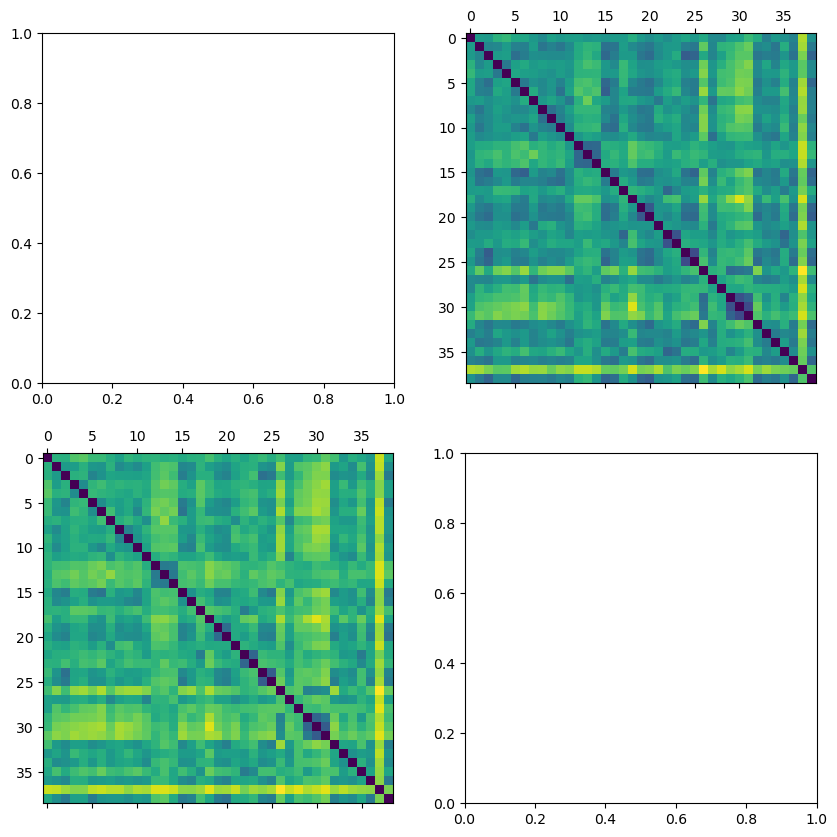

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.ravel()
# ax[0].matshow(D["jc69"].values)
ax[1].matshow(D["k80"].values)
ax[2].matshow(D["raw"].values)
# ax[3].matshow(D["jaccard"].values)

## Computations

In [6]:
import scipy.special
def get_p(X):
    largest = X.max(axis=1)
    second_largest = np.partition(X, -2, axis=1)[:, -2]
    return second_largest/largest

T_ENERGY = 1

def calc_classifier_metrics(df_pred, n_col):
    """Calculate the classification entropy from predictions and adds them to the end of the dataframe"""
    predX = df_pred.values[:,2:n_col].astype(np.float64)
    softmax = scipy.special.softmax(predX, axis=1)

    df_pred["H"] = -np.sum(softmax*np.log(softmax),axis=1)
    df_pred["MSP"] = -softmax.max(axis=1)
    df_pred["MaxLogit"] = -predX.max(axis=1)
    df_pred["energy"] = -T_ENERGY*scipy.special.logsumexp(predX/T_ENERGY, axis=1)
    # Calculate the ratio between max probable class and the second most probable
    df_pred["r_softmax"] = get_p(softmax)
    df_pred["r_logit"] = get_p(predX)

    return df_pred

def re_order_preds(label, D, df_pred, sorting_key):
    """Re-orders predictions based on the proximity matrix D"""

    candidate_order = D.loc[label].sort_values(ascending=True).drop(label)
    block_list = []
    for candidate in candidate_order.index:
        block = df_pred.sort_values(sorting_key, ascending=False).query("y_pred == @candidate")[[sorting_key, "is_outlier"]]
        block_list.append(block)

    sorted_df_dna = pd.concat(block_list)
    return sorted_df_dna

def re_order_quantile(label, D, df_pred, sorting_key, q_p=0.6):
    """Re-orders predictions in two parts: first the top 80 quantile of sorting_key values
    and after that the last 20 quantile"""

    q = df_pred[sorting_key].quantile(q_p)
    sorted = df_pred.sort_values(sorting_key, ascending=False)
    over_threshold = sorted[sorted[sorting_key]>q]
    under_threshold = sorted[sorted[sorting_key]<=q]

    return pd.concat((re_order_preds(label, D, over_threshold, sorting_key),
                      re_order_preds(label, D, under_threshold, sorting_key)), axis=0)

METHODS = ["H", "MSP", "MaxLogit", "r_logit", "r_softmax", "energy"]

def calculate_dfs_from_distances(label, df_pred, D):
    sorted_dfs = {}
    sorted_dfs["dna"] = {}
    sorted_dfs["dna_quantile"] = {}
    for method in METHODS:
        sorted_dfs["dna"][method] = re_order_preds(label, D, df_pred, method)
        sorted_dfs["dna_quantile"][method] = re_order_quantile(label, D, df_pred, method)
    return sorted_dfs

def calculate_all_dfs(label, df_pred, D):
    sorted_dfs = {}
    sorted_dfs["by_cnn"] = {}
    for method in METHODS:
        sorted_dfs["by_cnn"][method] = df_pred.sort_values(by=method, ascending=False)[[method, "is_outlier"]]

    sorted_dfs["by_dna"] = {}
    for key in D.keys():
        sorted_dfs["by_dna"][key] = {}
        sorted_dfs["by_dna"][key] = calculate_dfs_from_distances(label, df_pred, D[key])
    sorted_dfs["y_pred"] = np.linspace(1,0, len(sorted_dfs["by_cnn"]["H"])) # the H does not matter
    return sorted_dfs

In [6]:
label, model_name = next(iter(zip(config["labels"], config["ckpts"])))
label = "Oxyethira_sp"
model_name =  "outputs/finbenthic2/dnaimg_Oxyethira_sp_efficientnet_b0/f0/dnaimg_Oxyethira_sp_efficientnet_b0_f0_240111-0736-7249_epoch27_val-loss0.22.ckpt"

#label = "Baetis_rhodani"
#model_name = "outputs/finbenthic2/dnaimg_Baetis_rhodani_efficientnet_b0/f0/dnaimg_Baetis_rhodani_efficientnet_b0_f0_240111-0352-534c_epoch11_val-loss0.24.ckpt"

df_pred, n_col = load_data(label, model_name)
df_pred = calc_classifier_metrics(df_pred, n_col)
sorted_dfs = calculate_all_dfs(label, df_pred, D)
sorted_dfs

{'by_cnn': {'H':                                                                H  is_outlier
  img                                                                         
  0-Oxyethira122.2.2016-07-23-15-795819000000-utc...  2.520365e+00           1
  0-Oxyethira122.1.2016-07-23-15-620135000000-utc...  2.498804e+00           1
  0-Oxyethira122.1.2016-07-23-15-417720000000-utc...  2.482904e+00           1
  1-Sphaerium97.1.2016-11-54-02-031052000000-utc.png  2.447143e+00           0
  0-Taeniopteryx_neb142.1.2016-07-11-45-578755000...  2.439007e+00           0
  ...                                                          ...         ...
  0-Agapetus114.1.2016-10-19-16-276047000000-utc.png  1.554700e-13           0
  0-Agapetus114.1.2016-10-19-16-469097000000-utc.png  1.476764e-13           0
  1-Agapetus247.1.2016-12-04-53-239426000000-utc.png  1.290789e-13           0
  1-Agapetus247.1.2016-12-04-53-160174000000-utc.png  1.106352e-13           0
  1-Agapetus247.1.2016-12-04-52-94137

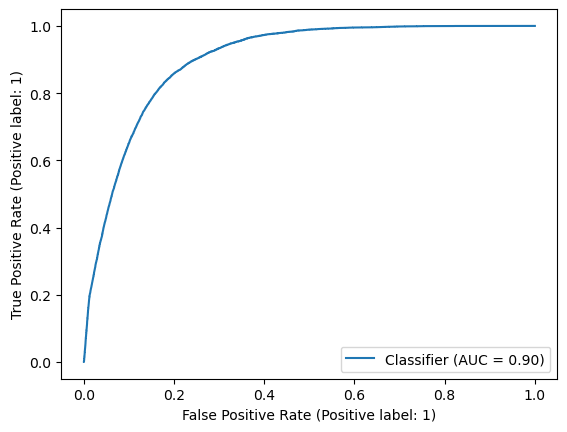

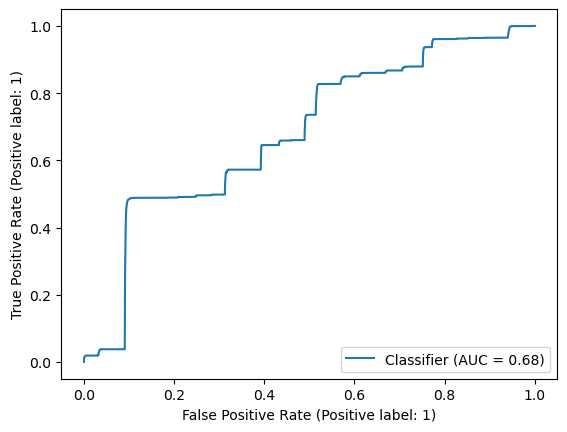

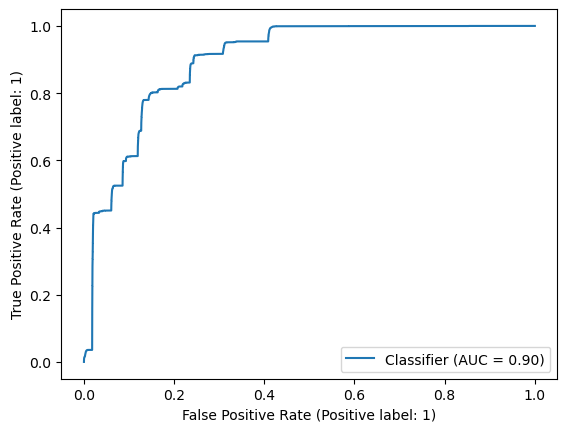

In [7]:
y_pred = sorted_dfs["y_pred"] 
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

cnn_metric = "MSP"
dna_distance = "k80"
RocCurveDisplay.from_predictions(
    sorted_dfs["by_cnn"][cnn_metric].is_outlier,
    y_pred
)
RocCurveDisplay.from_predictions(
    sorted_dfs["by_dna"][dna_distance]["dna"][cnn_metric].is_outlier,
    y_pred
)
display = RocCurveDisplay.from_predictions(
    sorted_dfs["by_dna"][dna_distance]["dna_quantile"][cnn_metric].is_outlier,
    y_pred
)

[]

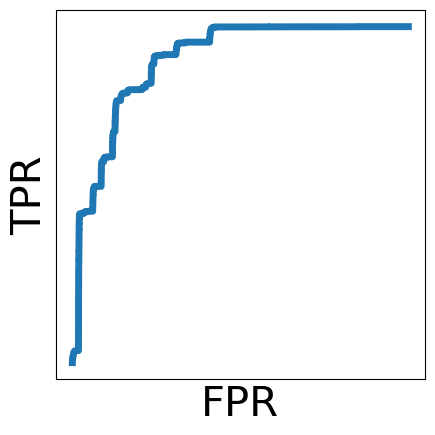

In [8]:
display = RocCurveDisplay.from_predictions(
    sorted_dfs["by_dna"][dna_distance]["dna_quantile"][cnn_metric].is_outlier,
    y_pred
)
ax = display.ax_
ax.lines[0].set_linewidth(5)
ax.set_xlabel("FPR", fontdict={"size": 30})
ax.set_ylabel("TPR", fontdict={"size": 30})
ax.get_legend().remove()
ax.set(xlim=(-0.05,1.05), ylim=(-0.05,1.05))
ax.set_aspect("equal", "box")
ax.set_xticks([])
ax.set_yticks([])

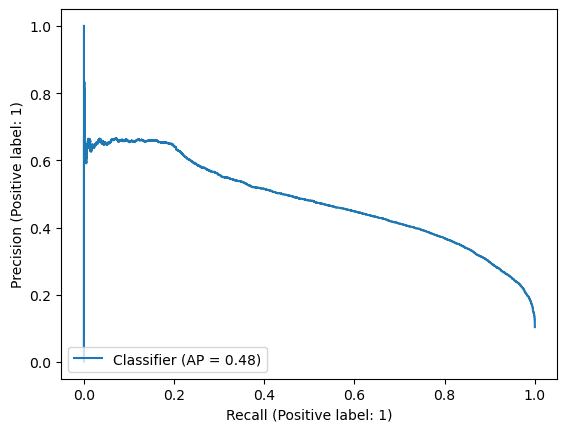

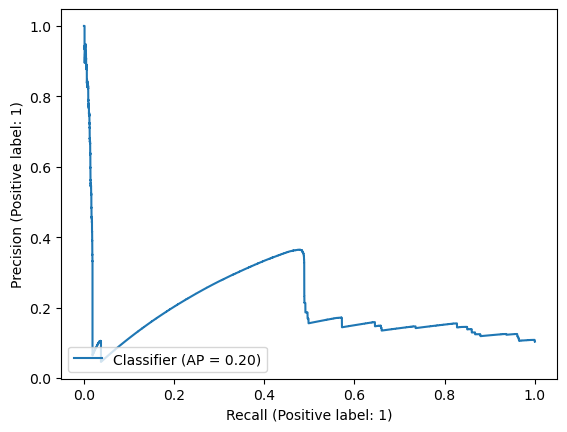

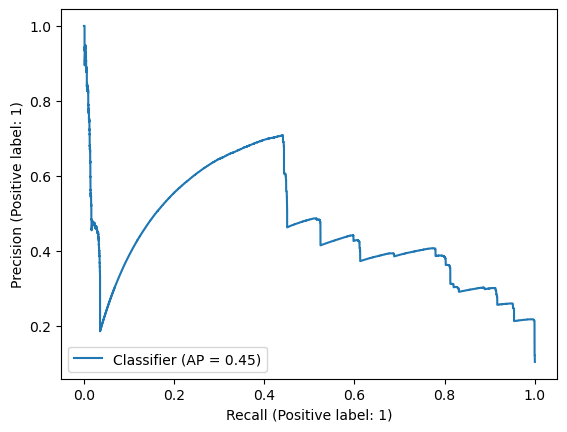

In [9]:
PrecisionRecallDisplay.from_predictions(
    sorted_dfs["by_cnn"][cnn_metric].is_outlier,
    y_pred
)
PrecisionRecallDisplay.from_predictions(
    sorted_dfs["by_dna"][dna_distance]["dna"][cnn_metric].is_outlier,
    y_pred
)
PrecisionRecallDisplay.from_predictions(
    sorted_dfs["by_dna"][dna_distance]["dna_quantile"][cnn_metric].is_outlier,
    y_pred
)

[]

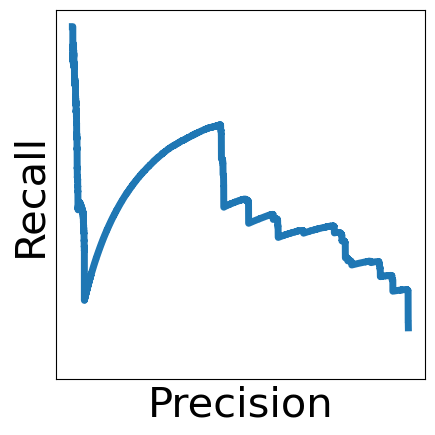

In [10]:
display = PrecisionRecallDisplay.from_predictions(
    sorted_dfs["by_dna"][dna_distance]["dna_quantile"][cnn_metric].is_outlier,
    y_pred
)
ax = display.ax_
ax.lines[0].set_linewidth(5)
ax.set_xlabel("Precision", fontdict={"size": 30})
ax.set_ylabel("Recall", fontdict={"size": 30})
ax.get_legend().remove()
ax.set(xlim=(-0.05,1.05), ylim=(-0.05,1.05))
ax.set_aspect("equal", adjustable="box")
ax.set_xticks([])
ax.set_yticks([])

In [11]:
df_pred

,y_true,y_pred,Oxyethira_sp,Agapetus_sp,Ameletus_inopinatus,Amphinemura_borealis,Baetis_rhodani,Baetis_vernus_group,Capnopsis_schilleri,Diura_sp,...,Simuliidae,Sphaerium_sp,Taeniopteryx_nebulosa,is_outlier,H,MSP,MaxLogit,energy,r_softmax,r_logit
img,,,,,,,,,,,,,,,,,,,,,
1-Agapetus1.1.2016-08-48-34-372709000000-utc.png,Agapetus_sp,Agapetus_sp,-3.898140,30.126910,-1.008480,-1.779062,-2.213071,-1.626129,-3.043184,-11.814165,...,-6.118086,-1.225135,-5.398592,0,2.389013e-08,-1.000000,-30.126910,-30.126910,1.039152e-09,0.313409
1-Agapetus1.1.2016-08-48-33-972737000000-utc.png,Agapetus_sp,Agapetus_sp,-4.120951,28.229445,-0.407131,-1.238021,-3.167002,-1.177266,-2.278676,-11.415027,...,-6.187974,-1.483489,-4.383622,0,9.415230e-08,-1.000000,-28.229445,-28.229445,4.296457e-09,0.317540
1-Agapetus1.1.2016-08-48-34-729001000000-utc.png,Agapetus_sp,Agapetus_sp,-4.042582,31.565813,-1.538731,-3.144690,-2.478778,0.789342,-4.506390,-11.904882,...,-5.410222,-1.957270,-5.878779,0,6.699307e-09,-1.000000,-31.565813,-31.565813,2.629942e-10,0.301178
0-Agapetus1.1.2016-08-48-34-496196000000-utc.png,Agapetus_sp,Agapetus_sp,-4.820115,34.550907,-0.833512,-3.362595,0.886126,-3.391955,-2.852801,-10.981709,...,-3.795208,-3.812334,-4.862781,0,1.370720e-10,-1.000000,-34.550907,-34.550907,3.734680e-12,0.238418
0-Agapetus1.1.2016-08-48-34-088420000000-utc.png,Agapetus_sp,Agapetus_sp,-4.316134,34.517260,-0.033944,-2.857339,0.277169,-3.011455,-1.347860,-11.996842,...,-4.660512,-2.897716,-5.292971,0,5.829963e-11,-1.000000,-34.517260,-34.517260,1.699164e-12,0.214860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0-Taeniopteryx_neb94.1.2016-05-56-06-298890000000-utc.png,Taeniopteryx_nebulosa,Taeniopteryx_nebulosa,-8.428884,-3.218445,-3.796934,-1.588123,1.964737,5.012449,-0.115412,10.249236,...,-4.254633,1.040807,19.421255,0,1.912304e-01,-0.970147,-10.249236,-10.279543,1.383523e-02,0.582356
0-Taeniopteryx_neb94.1.2016-05-56-04-784284000000-utc.png,Taeniopteryx_nebulosa,Taeniopteryx_nebulosa,-9.024082,-5.217459,-3.273909,-0.845434,2.738680,5.635140,-2.071360,7.900803,...,-2.209326,2.180381,16.529642,0,1.474398e+00,-0.565334,-7.900803,-8.471142,3.365546e-01,0.862167
0-Taeniopteryx_neb94.1.2016-05-56-06-654017000000-utc.png,Taeniopteryx_nebulosa,Taeniopteryx_nebulosa,-8.506291,-3.163033,-3.512473,-1.503207,1.915342,4.866553,-0.372210,10.162759,...,-4.251544,0.796810,18.723715,0,1.994696e-01,-0.969663,-10.162759,-10.193566,1.078956e-02,0.554336


In [12]:
from sklearn.metrics import roc_curve
def fpr_at_95(y_true, y_pred):
    roc = roc_curve(y_true, y_pred)
    fpr = roc[0]
    tpr = roc[1]
    return fpr[np.where(tpr > 0.95)[0][0]]

In [13]:
from sklearn.metrics import roc_auc_score, average_precision_score

def calc_metrics(sorted_df):
    y_pred = np.linspace(1,0, len(sorted_df))
    auc = roc_auc_score(
        sorted_df.is_outlier,
        y_pred
    )
    ap = average_precision_score(
        sorted_df.is_outlier,
        y_pred
    )
    fpr95 = fpr_at_95(
        sorted_df.is_outlier,
        y_pred
    )

    return {"auc": auc, "ap":ap, "fpr95": fpr95}
def calc_all_metrics(sorted_dfs):
    m_list = []

    # The ordered sequences based only cnn:s have different amount of keys
    # and are calculated separately from the dna ordered sequences
    for cnn_metric in sorted_dfs["by_cnn"].keys():
        m = {"type": "cnn",
             "dna_distance": None,
             "method": None,
             "cnn_metric": cnn_metric}
        m.update(calc_metrics(sorted_dfs["by_cnn"][cnn_metric]))
        m_list.append(m)

    for dna_distance in sorted_dfs["by_dna"].keys():
        dna_dfs = sorted_dfs["by_dna"][dna_distance]
        for method in dna_dfs.keys():
            method_dfs = dna_dfs[method]
            for cnn_metric in method_dfs.keys():
                m = {"type": "dna",
                     "dna_distance": dna_distance,
                     "method": method,
                     "cnn_metric": cnn_metric}
                m.update(calc_metrics(sorted_dfs["by_dna"][dna_distance][method][cnn_metric]))
                m_list.append(m)

    return pd.DataFrame(m_list)

metric_df = calc_all_metrics(sorted_dfs)
metric_df.query("method=='dna_quantile'")

,type,dna_distance,method,cnn_metric,auc,ap,fpr95
12,dna,k80,dna_quantile,H,0.899465,0.456183,0.312208
13,dna,k80,dna_quantile,MSP,0.898571,0.452960,0.313812
14,dna,k80,dna_quantile,MaxLogit,0.918027,0.494331,0.232680
15,dna,k80,dna_quantile,r_logit,0.850233,0.360816,0.418590
16,dna,k80,dna_quantile,r_softmax,0.893877,0.441913,0.409646
17,dna,k80,dna_quantile,energy,0.918066,0.494119,0.232669
24,dna,raw,dna_quantile,H,0.900571,0.467770,0.312208
25,dna,raw,dna_quantile,MSP,0.899677,0.464539,0.313812
26,dna,raw,dna_quantile,MaxLogit,0.918060,0.499694,0.249967
27,dna,raw,dna_quantile,r_logit,0.851429,0.370907,0.418590


In [302]:
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
def parallel_func(label, model_name):
    df_pred, n_col = load_data(label, model_name)
    df_pred = calc_classifier_metrics(df_pred, n_col)
    sorted_dfs = calculate_all_dfs(label, df_pred, D)

    metric_df = calc_all_metrics(sorted_dfs)
    metric_df.insert(0, "label", label)
    return metric_df

metric_dfs = Parallel(n_jobs=18)(delayed(parallel_func)(label, model_name) for label, model_name in tqdm(zip(config["labels"], config["ckpts"]), total=len(config["labels"])))

  0%|          | 0/39 [00:00<?, ?it/s]

In [359]:

def calc_only_quantile(label, model_name):
    df_pred, n_col = load_data(label, model_name)
    df_pred = calc_classifier_metrics(df_pred, n_col)

    mlist = []
    for q in tqdm(np.arange(1,10)/10):
        order = re_order_quantile(label, D["k80"], df_pred, "MaxLogit", q)
        m = calc_metrics(order)
        m["q"] = q
        m["label"] = label
        mlist.append(m)
    return mlist


quantile_dfs = Parallel(n_jobs=18)(delayed(calc_only_quantile)(label, model_name) for label, model_name in tqdm(zip(config["labels"], config["ckpts"]), total=len(config["labels"])))

  0%|          | 0/39 [00:00<?, ?it/s]

In [392]:
qdf = pd.DataFrame([
    x
    for xs in quantile_dfs
    for x in xs
]).melt(id_vars= ["q", "label"], value_vars=["auc", "ap", "fpr95"], var_name="metric")
qdf.to_csv("../data/processed/qdf.csv", index=False)

In [7]:
qdf = pd.read_csv("../data/processed/qdf.csv")
qdf

,q,label,metric,value
0,0.1,Agapetus_sp,auc,0.459775
1,0.2,Agapetus_sp,auc,0.537280
2,0.3,Agapetus_sp,auc,0.609980
3,0.4,Agapetus_sp,auc,0.679244
4,0.5,Agapetus_sp,auc,0.745037
...,...,...,...,...
1048,0.5,Taeniopteryx_nebulosa,fpr95,0.479301
1049,0.6,Taeniopteryx_nebulosa,fpr95,0.405563
1050,0.7,Taeniopteryx_nebulosa,fpr95,0.344456
1051,0.8,Taeniopteryx_nebulosa,fpr95,0.291706


In [304]:
score_df = pd.concat(metric_dfs).melt(id_vars=["label", "type", "dna_distance", "method", "cnn_metric"], var_name="score")
score_df["method"] = score_df["method"].fillna("cnn")
score_df["dna_distance"] = score_df["dna_distance"].fillna("cnn")
score_df

,label,type,dna_distance,method,cnn_metric,score,value
0,Agapetus_sp,cnn,cnn,cnn,H,auc,0.907104
1,Agapetus_sp,cnn,cnn,cnn,MSP,auc,0.898318
2,Agapetus_sp,cnn,cnn,cnn,MaxLogit,auc,0.946530
3,Agapetus_sp,cnn,cnn,cnn,r_logit,auc,0.827567
4,Agapetus_sp,cnn,cnn,cnn,r_softmax,auc,0.887685
...,...,...,...,...,...,...,...
3505,Taeniopteryx_nebulosa,dna,raw,dna_quantile,MSP,fpr95,0.403709
3506,Taeniopteryx_nebulosa,dna,raw,dna_quantile,MaxLogit,fpr95,0.405563
3507,Taeniopteryx_nebulosa,dna,raw,dna_quantile,r_logit,fpr95,0.440086
3508,Taeniopteryx_nebulosa,dna,raw,dna_quantile,r_softmax,fpr95,0.406751


In [305]:
score_df.to_csv("../data/processed/score_df.csv", index=False)

In [8]:
score_df = pd.read_csv("../data/processed/score_df.csv")
score_df


,label,type,dna_distance,method,cnn_metric,score,value
0,Agapetus_sp,cnn,cnn,cnn,H,auc,0.907104
1,Agapetus_sp,cnn,cnn,cnn,MSP,auc,0.898318
2,Agapetus_sp,cnn,cnn,cnn,MaxLogit,auc,0.946530
3,Agapetus_sp,cnn,cnn,cnn,r_logit,auc,0.827567
4,Agapetus_sp,cnn,cnn,cnn,r_softmax,auc,0.887685
...,...,...,...,...,...,...,...
3505,Taeniopteryx_nebulosa,dna,raw,dna_quantile,MSP,fpr95,0.403709
3506,Taeniopteryx_nebulosa,dna,raw,dna_quantile,MaxLogit,fpr95,0.405563
3507,Taeniopteryx_nebulosa,dna,raw,dna_quantile,r_logit,fpr95,0.440086
3508,Taeniopteryx_nebulosa,dna,raw,dna_quantile,r_softmax,fpr95,0.406751


In [9]:
score_df[score_df["dna_distance"].isin(["k80", "raw",None])].query("cnn_metric == 'H'")

,label,type,dna_distance,method,cnn_metric,score,value
6,Agapetus_sp,dna,k80,dna,H,auc,0.380397
12,Agapetus_sp,dna,k80,dna_quantile,H,auc,0.797016
18,Agapetus_sp,dna,raw,dna,H,auc,0.371636
24,Agapetus_sp,dna,raw,dna_quantile,H,auc,0.791384
36,Ameletus_inopinatus,dna,k80,dna,H,auc,0.563628
...,...,...,...,...,...,...,...
3474,Sphaerium_sp,dna,raw,dna_quantile,H,fpr95,0.933423
3486,Taeniopteryx_nebulosa,dna,k80,dna,H,fpr95,0.233821
3492,Taeniopteryx_nebulosa,dna,k80,dna_quantile,H,fpr95,0.402736
3498,Taeniopteryx_nebulosa,dna,raw,dna,H,fpr95,0.233821


In [10]:
k80 = score_df[score_df["dna_distance"].isin(["cnn", "k80"])]
overall_table = pd.DataFrame(k80.groupby(["score", "cnn_metric", "method", "dna_distance"])["value"].mean()).reset_index()
overall_table_std = pd.DataFrame(k80.groupby(["score", "cnn_metric", "method", "dna_distance"])["value"].std()).reset_index()

overall_table = overall_table.drop("dna_distance",axis=1).pivot(index=["cnn_metric", "method"], columns=["score"])["value"]
overall_table_std = overall_table_std.drop("dna_distance",axis=1).pivot(index=["cnn_metric", "method"], columns=["score"]).round(2)["value"]
overall_table.fillna("")

score                          ap       auc     fpr95
cnn_metric method                                    
H          cnn           0.317114  0.807661  0.501358
           dna           0.444093  0.805916  0.466732
           dna_quantile  0.469399  0.864233  0.390162
MSP        cnn           0.302114  0.803823  0.503191
           dna           0.443017  0.805804  0.466862
           dna_quantile  0.467524  0.863388  0.395479
MaxLogit   cnn           0.319356  0.800955  0.492781
           dna           0.446655  0.806232  0.467985
           dna_quantile  0.454852  0.855935  0.337004
energy     cnn           0.317454  0.799916  0.492830
           dna           0.446606  0.806228  0.468060
           dna_quantile  0.453787  0.855193  0.335151
r_logit    cnn           0.252951  0.761697  0.605358
           dna           0.434922  0.804252  0.469070
           dna_quantile  0.435642  0.833167  0.489875
r_softmax  cnn           0.281619  0.798329  0.511052
           dna           0.441699  0.805628  0.467122
           dna_quantile  0.463617  0.860657  0.408354

In [11]:
overall_table_std

score                      ap   auc  fpr95
cnn_metric method                         
H          cnn           0.22  0.10   0.17
           dna           0.26  0.18   0.30
           dna_quantile  0.24  0.06   0.13
MSP        cnn           0.21  0.09   0.17
           dna           0.26  0.18   0.30
           dna_quantile  0.24  0.06   0.14
MaxLogit   cnn           0.24  0.13   0.24
           dna           0.26  0.18   0.30
           dna_quantile  0.22  0.06   0.08
energy     cnn           0.23  0.13   0.24
           dna           0.26  0.18   0.30
           dna_quantile  0.22  0.06   0.09
r_logit    cnn           0.17  0.10   0.13
           dna           0.26  0.18   0.30
           dna_quantile  0.24  0.08   0.17
r_softmax  cnn           0.19  0.09   0.16
           dna           0.26  0.18   0.30
           dna_quantile  0.24  0.07   0.14

In [12]:
def format_cell(x, d):
    if d == 2:
        x = f"{x:.2f}"
    if d == 3:
        x = f"{x:.3f}"

    if x == 'nan':
        return ''
    return x

def format_empty(x):
    if x.strip() == "($\pm$)":
        return ''
    return x


overall_latex = overall_table.map(lambda x: format_cell(x, 3)) + " ($\pm$" + overall_table_std.map(lambda x: format_cell(x, 2)) + ")"
overall_latex = overall_latex.map(format_empty)
overall_latex

score                                   ap                auc  \
cnn_metric method                                               
H          cnn           0.317 ($\pm$0.22)  0.808 ($\pm$0.10)   
           dna           0.444 ($\pm$0.26)  0.806 ($\pm$0.18)   
           dna_quantile  0.469 ($\pm$0.24)  0.864 ($\pm$0.06)   
MSP        cnn           0.302 ($\pm$0.21)  0.804 ($\pm$0.09)   
           dna           0.443 ($\pm$0.26)  0.806 ($\pm$0.18)   
           dna_quantile  0.468 ($\pm$0.24)  0.863 ($\pm$0.06)   
MaxLogit   cnn           0.319 ($\pm$0.24)  0.801 ($\pm$0.13)   
           dna           0.447 ($\pm$0.26)  0.806 ($\pm$0.18)   
           dna_quantile  0.455 ($\pm$0.22)  0.856 ($\pm$0.06)   
energy     cnn           0.317 ($\pm$0.23)  0.800 ($\pm$0.13)   
           dna           0.447 ($\pm$0.26)  0.806 ($\pm$0.18)   
           dna_quantile  0.454 ($\pm$0.22)  0.855 ($\pm$0.06)   
r_logit    cnn           0.253 ($\pm$0.17)  0.762 ($\pm$0.10)   
           dna           0.435 ($\pm$0.26)  0.804 ($\pm$0.18)   
           dna_quantile  0.436 ($\pm$0.24)  0.833 ($\pm$0.08)   
r_softmax  cnn           0.282 ($\pm$0.19)  0.798 ($\pm$0.09)   
           dna           0.442 ($\pm$0.26)  0.806 ($\pm$0.18)   
           dna_quantile  0.464 ($\pm$0.24)  0.861 ($\pm$0.07)   

score                                fpr95  
cnn_metric method                           
H          cnn           0.501 ($\pm$0.17)  
           dna           0.467 ($\pm$0.30)  
           dna_quantile  0.390 ($\pm$0.13)  
MSP        cnn           0.503 ($\pm$0.17)  
           dna           0.467 ($\pm$0.30)  
           dna_quantile  0.395 ($\pm$0.14)  
MaxLogit   cnn           0.493 ($\pm$0.24)  
           dna           0.468 ($\pm$0.30)  
           dna_quantile  0.337 ($\pm$0.08)  
energy     cnn           0.493 ($\pm$0.24)  
           dna           0.468 ($\pm$0.30)  
           dna_quantile  0.335 ($\pm$0.09)  
r_logit    cnn           0.605 ($\pm$0.13)  
           dna           0.469 ($\pm$0.30)  
           dna_quantile  0.490 ($\pm$0.17)  
r_softmax  cnn           0.511 ($\pm$0.16)  
           dna           0.467 ($\pm$0.30)  
           dna_quantile  0.408 ($\pm$0.14)

In [13]:
print(overall_latex.to_latex())

\begin{tabular}{lllll}
\toprule
 & score & ap & auc & fpr95 \\
cnn_metric & method &  &  &  \\
\midrule
\multirow[t]{3}{*}{H} & cnn & 0.317 ($\pm$0.22) & 0.808 ($\pm$0.10) & 0.501 ($\pm$0.17) \\
 & dna & 0.444 ($\pm$0.26) & 0.806 ($\pm$0.18) & 0.467 ($\pm$0.30) \\
 & dna_quantile & 0.469 ($\pm$0.24) & 0.864 ($\pm$0.06) & 0.390 ($\pm$0.13) \\
\cline{1-5}
\multirow[t]{3}{*}{MSP} & cnn & 0.302 ($\pm$0.21) & 0.804 ($\pm$0.09) & 0.503 ($\pm$0.17) \\
 & dna & 0.443 ($\pm$0.26) & 0.806 ($\pm$0.18) & 0.467 ($\pm$0.30) \\
 & dna_quantile & 0.468 ($\pm$0.24) & 0.863 ($\pm$0.06) & 0.395 ($\pm$0.14) \\
\cline{1-5}
\multirow[t]{3}{*}{MaxLogit} & cnn & 0.319 ($\pm$0.24) & 0.801 ($\pm$0.13) & 0.493 ($\pm$0.24) \\
 & dna & 0.447 ($\pm$0.26) & 0.806 ($\pm$0.18) & 0.468 ($\pm$0.30) \\
 & dna_quantile & 0.455 ($\pm$0.22) & 0.856 ($\pm$0.06) & 0.337 ($\pm$0.08) \\
\cline{1-5}
\multirow[t]{3}{*}{energy} & cnn & 0.317 ($\pm$0.23) & 0.800 ($\pm$0.13) & 0.493 ($\pm$0.24) \\
 & dna & 0.447 ($\pm$0.26) & 0.806 

In [14]:
score_described = score_df.pivot(index="label", columns=["cnn_metric", "score", "type", "dna_distance", "method"])["value"]["MaxLogit"].describe()
score_described.reorder_levels([0,3,1,2], axis=1)["auc"][["cnn", "dna_quantile"]]

method              cnn dna_quantile           
type                cnn          dna           
dna_distance        cnn          k80        raw
count         39.000000    39.000000  39.000000
mean           0.800955     0.855935   0.855658
std            0.129144     0.062580   0.063231
min            0.542989     0.715854   0.716180
25%            0.712285     0.802747   0.800233
50%            0.843952     0.871297   0.871625
75%            0.911459     0.906900   0.904620
max            0.960305     0.949649   0.948503

In [15]:
comparison_df = score_df.query("dna_distance == 'k80' or dna_distance == 'cnn'").query("(method == 'cnn') or (method == 'dna_quantile')").query("score == 'auc'").drop(["dna_distance", "method", "score"], axis=1)
comparison_df = comparison_df.pivot(index=["label", "cnn_metric"], columns=["type"])["value"]
comparison_df["diff"] =  (comparison_df["dna"] - comparison_df["cnn"])/comparison_df["dna"]
cm_df = comparison_df["diff"].reset_index().pivot(index="cnn_metric", columns="label")
cm = cm_df.values

In [16]:
cm_df

diff                                           \
label      Agapetus_sp Ameletus_inopinatus Amphinemura_borealis   
cnn_metric                                                        
H            -0.138126           -0.089496            -0.032140   
MSP          -0.128528           -0.086450            -0.019156   
MaxLogit     -0.170935           -0.109941            -0.053432   
energy       -0.171219           -0.108778            -0.052458   
r_logit      -0.138053           -0.072451             0.004102   
r_softmax    -0.121299           -0.084238            -0.006713   

                                                                             \
label      Baetis_rhodani Baetis_vernus_group Capnopsis_schilleri  Diura_sp   
cnn_metric                                                                    
H                0.107300            0.222557            0.029605  0.159320   
MSP              0.108281            0.224192            0.038029  0.159218   
MaxLogit         0.111802            0.151822           -0.010507  0.176552   
energy           0.112560            0.151319           -0.010311  0.176878   
r_logit          0.112767            0.304024            0.087534  0.163889   
r_softmax        0.109150            0.225269            0.047823  0.159021   

                                                                     ...  \
label      Elmis_aenea Ephemerella_aurivillii Ephemerella_mucronata  ...   
cnn_metric                                                           ...   
H             0.157143              -0.037142              0.027281  ...   
MSP           0.157898              -0.028160              0.036128  ...   
MaxLogit      0.169538              -0.073394              0.001581  ...   
energy        0.170269              -0.073415              0.002032  ...   
r_logit       0.160242              -0.001829              0.075720  ...   
r_softmax     0.157830              -0.020575              0.045855  ...   

                                                          \
label      Plectrocnemia_sp Polycentropus_flavomaculatus   
cnn_metric                                                 
H                  0.131433                     0.140546   
MSP                0.131069                     0.138546   
MaxLogit           0.186457                     0.293591   
energy             0.189049                     0.297128   
r_logit            0.130296                     0.113863   
r_softmax          0.131411                     0.136036   

                                                                      \
label      Polycentropus_irroratus Protonemura_sp Rhyacophila_nubila   
cnn_metric                                                             
H                         0.224903       0.072364          -0.140172   
MSP                       0.224338       0.075399          -0.131540   
MaxLogit                  0.286557       0.044780          -0.164068   
energy                    0.286688       0.045421          -0.163212   
r_logit                   0.211778       0.107192          -0.120255   
r_softmax                 0.223727       0.078283          -0.120773   

                                                            \
label      Sialis_sp Silo_pallipes Simuliidae Sphaerium_sp   
cnn_metric                                                   
H          -0.150162      0.241566  -0.104232    -0.243984   
MSP        -0.140735      0.244262  -0.096170    -0.231533   
MaxLogit   -0.231747      0.167913  -0.069316    -0.252397   
energy     -0.233481      0.167262  -0.067523    -0.258349   
r_logit    -0.129325      0.355609  -0.103969    -0.272214   
r_softmax  -0.134949      0.251547  -0.093291    -0.229576   

                                  
label      Taeniopteryx_nebulosa  
cnn_metric                        
H                       0.033222  
MSP                     0.028479  
MaxLogit                0.087449  
energy                  0.090279  
r_logit                

In [17]:
maxval = max(abs(cm.max()), abs(cm.min()))
maxval

0.35560868618917785

C:\Users\E1007914\AppData\Local\Temp\ipykernel_28256\2448356508.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', "Entropy", "MSP", "MaxLogit", "Energy", "Ratio (logit)", "Ratio (softmax)"])


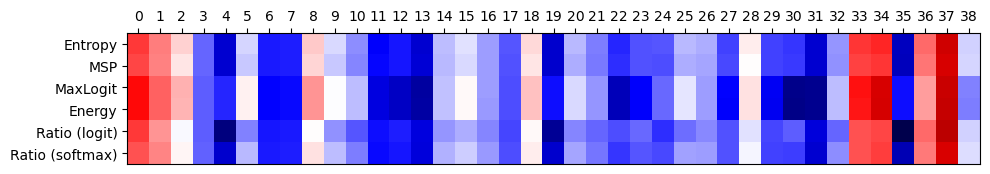

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(10)
sp = ax.matshow(-cm, cmap="seismic", vmax=maxval, vmin=-maxval)
ax.set_yticklabels(['', "Entropy", "MSP", "MaxLogit", "Energy", "Ratio (logit)", "Ratio (softmax)"])
ax.set_xticks(np.arange(39))
ax.set_xticklabels(np.arange(39), fontdict={"size": 10})
plt.tick_params(
    bottom=False
)
fig.tight_layout()
fig.savefig("species.pdf", bbox_inches="tight")
plt.show()

In [21]:
cm_df.mean(axis=0).sort_values()

      label                       
diff  Sphaerium_sp                   -0.248009
      Sialis_sp                      -0.170067
      Agapetus_sp                    -0.144693
      Rhyacophila_nubila             -0.140003
      Ameletus_inopinatus            -0.091893
      Simuliidae                     -0.089083
      Ephemerella_aurivillii         -0.039086
      Amphinemura_borealis           -0.026633
      Leptophlebia_sp                -0.024521
      Oxyethira_sp                   -0.004795
      Isoperla_sp                     0.021805
      Capnopsis_schilleri             0.030362
      Ephemerella_mucronata           0.031433
      Taeniopteryx_nebulosa           0.049261
      Nemoura_sp                      0.050781
      Leuctra_sp                      0.050886
      Hydropsyche_siltalai            0.051049
      Neureclipsis_bimaculata         0.067482
      Protonemura_sp                  0.070573
      Kageronia_fuscogrisea           0.071778
      Heptagenia_sulphure

In [22]:
from tqdm.notebook import tqdm
model_map = {k:v for k, v in zip(config["labels"], config["ckpts"])}

props = []
for label in tqdm(config["labels"]):
    df_pred, n_col = load_data(label, model_map[label])
    outliers = df_pred.query("y_true == @label")
    proportion = outliers["y_pred"].value_counts()/len(outliers)
    proportion.name = label
    props.append(proportion)

D_c = pd.DataFrame(props)

  0%|          | 0/39 [00:00<?, ?it/s]

In [23]:
D_c = D_c.fillna(0).sort_index()

In [24]:
D_c = D_c[D_c.index]
D_c

y_pred,Agapetus_sp,Ameletus_inopinatus,Amphinemura_borealis,Baetis_rhodani,Baetis_vernus_group,Capnopsis_schilleri,Diura_sp,Elmis_aenea,Ephemerella_aurivillii,Ephemerella_mucronata,...,Plectrocnemia_sp,Polycentropus_flavomaculatus,Polycentropus_irroratus,Protonemura_sp,Rhyacophila_nubila,Sialis_sp,Silo_pallipes,Simuliidae,Sphaerium_sp,Taeniopteryx_nebulosa
Agapetus_sp,0.000000,0.000139,0.094669,0.000070,0.000000,0.000417,0.000000,0.018489,0.000000,0.001460,...,0.000278,0.136165,0.013554,0.000000,0.031973,0.000000,0.001182,0.004448,0.000000,0.000000
Ameletus_inopinatus,0.000000,0.000000,0.000000,0.577687,0.017019,0.000000,0.000000,0.000000,0.004727,0.017334,...,0.000000,0.000000,0.000000,0.000000,0.000315,0.000000,0.000000,0.007091,0.000000,0.000000
Amphinemura_borealis,0.017764,0.000000,0.000000,0.003913,0.001801,0.220932,0.000000,0.096708,0.000000,0.055839,...,0.000000,0.009565,0.003727,0.000373,0.000000,0.000559,0.000186,0.002547,0.000000,0.004286
Baetis_rhodani,0.000403,0.066166,0.005749,0.000000,0.612335,0.000252,0.000000,0.000000,0.002169,0.008775,...,0.000101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001311,0.000000,0.000403
Baetis_vernus_group,0.000000,0.009199,0.006404,0.839427,0.000000,0.000000,0.029925,0.000000,0.038076,0.001514,...,0.001048,0.000000,0.000000,0.006637,0.000000,0.000116,0.000000,0.000233,0.000000,0.004425
Capnopsis_schilleri,0.005714,0.000000,0.507619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025714,...,0.000000,0.000952,0.000000,0.000000,0.000000,0.000000,0.000000,0.008571,0.000000,0.014286
Diura_sp,0.000000,0.000000,0.000000,0.002485,0.003162,0.000000,0.000000,0.000000,0.005873,0.000000,...,0.000000,0.000000,0.000000,0.136436,0.000000,0.000000,0.000000,0.000000,0.000000,0.016490
Elmis_aenea,0.018396,0.000185,0.057318,0.001266,0.001389,0.000123,0.000000,0.000000,0.000185,0.001790,...,0.000000,0.000000,0.000000,0.000000,0.000031,0.000000,0.000278,0.004043,0.000000,0.000309
Ephemerella_aurivillii,0.000122,0.012577,0.000000,0.138717,0.252825,0.000000,0.024183,0.000000,0.000000,0.257565,...,0.003828,0.000365,0.000304,0.018532,0.026674,0.000243,0.000000,0.000122,0.000000,0.017864
Ephemerella_mucronata,0.001647,0.004481,0.057397,0.028138,0.000066,0.037759,0.000461,0.001186,0.379242,0.000000,...,0.000857,0.006260,0.003427,0.000988,0.000000,0.000000,0.000000,0.000329,0.000000,0.015025


In [25]:
D_c_upper = np.log10(np.triu(D_c))
D_k80_upper = np.triu(D["k80"])

C:\Users\E1007914\AppData\Local\Temp\ipykernel_28256\2248155687.py:1: RuntimeWarning: divide by zero encountered in log10
  D_c_upper = np.log10(np.triu(D_c))


In [26]:
D["k80"]

,Agapetus_sp,Ameletus_inopinatus,Amphinemura_borealis,Baetis_rhodani,Baetis_vernus_group,Capnopsis_schilleri,Diura_sp,Elmis_aenea,Ephemerella_aurivillii,Ephemerella_mucronata,...,Plectrocnemia_sp,Polycentropus_flavomaculatus,Polycentropus_irroratus,Protonemura_sp,Rhyacophila_nubila,Sialis_sp,Silo_pallipes,Simuliidae,Sphaerium_sp,Taeniopteryx_nebulosa
Agapetus_sp,0.000000,0.303350,0.300392,0.355474,0.368173,0.330540,0.328199,0.294684,0.265572,0.316057,...,0.313629,0.319989,0.373838,0.341676,0.242463,0.297018,0.277235,0.247665,0.488609,0.280274
Ameletus_inopinatus,0.303350,0.000000,0.251670,0.259005,0.304620,0.244326,0.240408,0.306145,0.218692,0.245251,...,0.367866,0.399649,0.425362,0.253749,0.272601,0.220242,0.344400,0.232682,0.478129,0.227334
Amphinemura_borealis,0.300392,0.251670,0.000000,0.303350,0.310195,0.203172,0.234837,0.276651,0.271808,0.267613,...,0.374297,0.409785,0.410392,0.219931,0.237525,0.230001,0.289543,0.211626,0.443280,0.179710
Baetis_rhodani,0.355474,0.259005,0.303350,0.000000,0.221610,0.315583,0.337105,0.301378,0.314435,0.303534,...,0.393679,0.421177,0.448811,0.261364,0.327425,0.249913,0.331420,0.297617,0.411958,0.261963
Baetis_vernus_group,0.368173,0.304620,0.310195,0.221610,0.000000,0.325922,0.313243,0.307968,0.290873,0.280606,...,0.393679,0.434859,0.430693,0.262723,0.297617,0.296340,0.357651,0.296861,0.415303,0.266028
Capnopsis_schilleri,0.330540,0.244326,0.203172,0.315583,0.325922,0.000000,0.225605,0.280331,0.263397,0.292272,...,0.400200,0.444244,0.442479,0.226166,0.279332,0.244118,0.342915,0.246129,0.475064,0.185629
Diura_sp,0.328199,0.240408,0.234837,0.337105,0.313243,0.225605,0.000000,0.341898,0.260313,0.289561,...,0.418892,0.457823,0.435015,0.242449,0.299343,0.300465,0.389343,0.254663,0.489982,0.237365
Elmis_aenea,0.294684,0.306145,0.276651,0.301378,0.307968,0.280331,0.341898,0.000000,0.296095,0.323083,...,0.340126,0.383587,0.396172,0.270273,0.248248,0.248248,0.332948,0.262138,0.467231,0.241765
Ephemerella_aurivillii,0.265572,0.218692,0.271808,0.314435,0.290873,0.263397,0.260313,0.296095,0.000000,0.204173,...,0.382420,0.454639,0.455342,0.282133,0.281388,0.272767,0.324104,0.240650,0.468633,0.243382
Ephemerella_mucronata,0.316057,0.245251,0.267613,0.303534,0.280606,0.292272,0.289561,0.323083,0.204173,0.000000,...,0.369174,0.437575,0.429314,0.259211,0.319958,0.283561,0.351453,0.252498,0.425889,0.227470


In [27]:
D_c.reset_index()

y_pred,index,Agapetus_sp,Ameletus_inopinatus,Amphinemura_borealis,Baetis_rhodani,Baetis_vernus_group,Capnopsis_schilleri,Diura_sp,Elmis_aenea,Ephemerella_aurivillii,...,Plectrocnemia_sp,Polycentropus_flavomaculatus,Polycentropus_irroratus,Protonemura_sp,Rhyacophila_nubila,Sialis_sp,Silo_pallipes,Simuliidae,Sphaerium_sp,Taeniopteryx_nebulosa
0,Agapetus_sp,0.000000,0.000139,0.094669,0.000070,0.000000,0.000417,0.000000,0.018489,0.000000,...,0.000278,0.136165,0.013554,0.000000,0.031973,0.000000,0.001182,0.004448,0.000000,0.000000
1,Ameletus_inopinatus,0.000000,0.000000,0.000000,0.577687,0.017019,0.000000,0.000000,0.000000,0.004727,...,0.000000,0.000000,0.000000,0.000000,0.000315,0.000000,0.000000,0.007091,0.000000,0.000000
2,Amphinemura_borealis,0.017764,0.000000,0.000000,0.003913,0.001801,0.220932,0.000000,0.096708,0.000000,...,0.000000,0.009565,0.003727,0.000373,0.000000,0.000559,0.000186,0.002547,0.000000,0.004286
3,Baetis_rhodani,0.000403,0.066166,0.005749,0.000000,0.612335,0.000252,0.000000,0.000000,0.002169,...,0.000101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001311,0.000000,0.000403
4,Baetis_vernus_group,0.000000,0.009199,0.006404,0.839427,0.000000,0.000000,0.029925,0.000000,0.038076,...,0.001048,0.000000,0.000000,0.006637,0.000000,0.000116,0.000000,0.000233,0.000000,0.004425
5,Capnopsis_schilleri,0.005714,0.000000,0.507619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000952,0.000000,0.000000,0.000000,0.000000,0.000000,0.008571,0.000000,0.014286
6,Diura_sp,0.000000,0.000000,0.000000,0.002485,0.003162,0.000000,0.000000,0.000000,0.005873,...,0.000000,0.000000,0.000000,0.136436,0.000000,0.000000,0.000000,0.000000,0.000000,0.016490
7,Elmis_aenea,0.018396,0.000185,0.057318,0.001266,0.001389,0.000123,0.000000,0.000000,0.000185,...,0.000000,0.000000,0.000000,0.000000,0.000031,0.000000,0.000278,0.004043,0.000000,0.000309
8,Ephemerella_aurivillii,0.000122,0.012577,0.000000,0.138717,0.252825,0.000000,0.024183,0.000000,0.000000,...,0.003828,0.000365,0.000304,0.018532,0.026674,0.000243,0.000000,0.000122,0.000000,0.017864
9,Ephemerella_mucronata,0.001647,0.004481,0.057397,0.028138,0.000066,0.037759,0.000461,0.001186,0.379242,...,0.000857,0.006260,0.003427,0.000988,0.000000,0.000000,0.000000,0.000329,0.000000,0.015025


In [28]:
Dstack = D_c.stack()
Dstack

                       y_pred               
Agapetus_sp            Agapetus_sp              0.000000
                       Ameletus_inopinatus      0.000139
                       Amphinemura_borealis     0.094669
                       Baetis_rhodani           0.000070
                       Baetis_vernus_group      0.000000
                                                  ...   
Taeniopteryx_nebulosa  Sialis_sp                0.000061
                       Silo_pallipes            0.000000
                       Simuliidae               0.000000
                       Sphaerium_sp             0.000000
                       Taeniopteryx_nebulosa    0.000000
Length: 1521, dtype: float64

In [29]:
Dk80stack = D["k80"].stack()
Dk80stack

Agapetus_sp            Agapetus_sp              0.000000
                       Ameletus_inopinatus      0.303350
                       Amphinemura_borealis     0.300392
                       Baetis_rhodani           0.355474
                       Baetis_vernus_group      0.368173
                                                  ...   
Taeniopteryx_nebulosa  Sialis_sp                0.216709
                       Silo_pallipes            0.277333
                       Simuliidae               0.184151
                       Sphaerium_sp             0.402236
                       Taeniopteryx_nebulosa    0.000000
Length: 1521, dtype: float64

In [30]:
def process_annotation(s):
    if s == "Sphaerium_sp":
        return "Sphaerium"
    if s == "Polycentropus_irroratus":
        return "Polycentropus irroratus"
    return "Others"

In [31]:
D_combined = pd.DataFrame([Dstack, Dk80stack]).transpose().reset_index()
D_combined.columns = ["outlier", "inlier", "cnn", "dna"]
D_combined = D_combined.query("cnn != 0")
D_combined["log_cnn"] = np.log(D_combined["cnn"])
D_combined["annotation"] = D_combined["outlier"].apply(process_annotation)
D_combined

,outlier,inlier,cnn,dna,log_cnn,annotation
1,Agapetus_sp,Ameletus_inopinatus,0.000139,0.303350,-8.880933,Others
2,Agapetus_sp,Amphinemura_borealis,0.094669,0.300392,-2.357371,Others
3,Agapetus_sp,Baetis_rhodani,0.000070,0.355474,-9.574080,Others
5,Agapetus_sp,Capnopsis_schilleri,0.000417,0.330540,-7.782321,Others
7,Agapetus_sp,Elmis_aenea,0.018489,0.294684,-3.990584,Others
...,...,...,...,...,...,...
1503,Taeniopteryx_nebulosa,Limnius_volckmari,0.000123,0.285449,-9.007306,Others
1506,Taeniopteryx_nebulosa,Nemoura_cinerea,0.012312,0.201851,-4.397148,Others
1507,Taeniopteryx_nebulosa,Nemoura_sp,0.395100,0.187307,-0.928618,Others
1514,Taeniopteryx_nebulosa,Protonemura_sp,0.435283,0.194922,-0.831758,Others


c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categoric

PearsonRResult(statistic=-0.38269989765454027, pvalue=2.6208127147848496e-30)


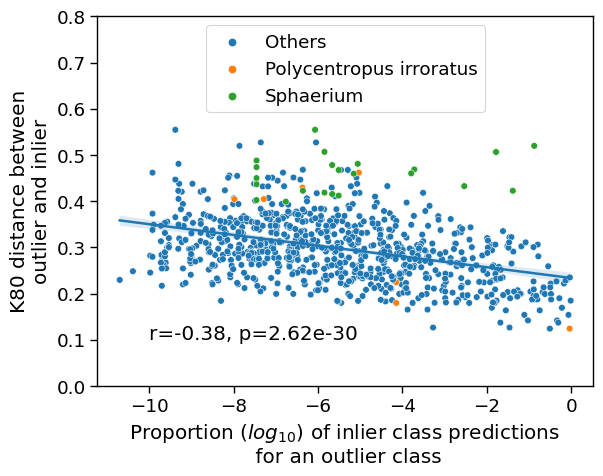

In [32]:
import seaborn as sns
from scipy import stats
sns.set_context("paper", font_scale=1.5)
g = sns.scatterplot(
    D_combined,
    x="log_cnn",
    y="dna",
    hue="annotation"
)
ax = g.axes
sns.regplot(D_combined,
            ax=ax,
            x="log_cnn",
            y="dna",
            scatter=False
            )
r = stats.pearsonr(D_combined["log_cnn"], D_combined["dna"])
print(r)
plt.ylim((0,0.8))
plt.xlabel("Proportion ($log_{10}$) of inlier class predictions \n for an outlier class")
plt.annotate(f"r={r.statistic:.2f}, p={r.pvalue:.2e}",
             xy=(-10, 0.1))
plt.legend(bbox_to_anchor=(0.8,1.0))
plt.ylabel("K80 distance between\noutlier and inlier")
plt.savefig("proportion_distance.pdf", bbox_inches="tight")

In [33]:
r

PearsonRResult(statistic=-0.38269989765454027, pvalue=2.6208127147848496e-30)

In [34]:
config["labels"][37]

'Sphaerium_sp'

In [35]:
np.where(np.array(config["labels"]) == label)

(array([38], dtype=int64),)

In [36]:
# where it is most likely to be mistaken for
def print_proportion(label):
    df_pred, _ = load_data(label, model_map[label])
    outliers = df_pred.query("y_true == @label")
    return outliers["y_pred"].value_counts()/len(outliers)
print_proportion("Sphaerium_sp")

y_pred
Oxyethira_sp                    0.414887
Simuliidae                      0.249856
Hydropsyche_pellucidula         0.167917
Silo_pallipes                   0.079054
Ephemerella_aurivillii          0.024235
Heptagenia_sulphurea            0.022504
Polycentropus_flavomaculatus    0.006347
Plectrocnemia_sp                0.005770
Baetis_rhodani                  0.004039
Elmis_aenea                     0.004039
Ameletus_inopinatus             0.003462
Baetis_vernus_group             0.003462
Kageronia_fuscogrisea           0.002885
Hydropsyche_saxonica            0.002885
Neureclipsis_bimaculata         0.002308
Isoperla_sp                     0.001731
Micrasema_gelidum               0.001154
Lepidostoma_hirtum              0.000577
Rhyacophila_nubila              0.000577
Nemoura_sp                      0.000577
Hydropsyche_siltalai            0.000577
Protonemura_sp                  0.000577
Taeniopteryx_nebulosa           0.000577
Name: count, dtype: float64

In [37]:
print_proportion("Polycentropus_irroratus")

y_pred
Polycentropus_flavomaculatus    0.959205
Neureclipsis_bimaculata         0.015770
Plectrocnemia_sp                0.015770
Leptophlebia_sp                 0.006514
Ephemerella_mucronata           0.001714
Lepidostoma_hirtum              0.000686
Heptagenia_sulphurea            0.000343
Name: count, dtype: float64

In [42]:
print_proportion("Polycentropus_flavomaculatus")

y_pred
Polycentropus_irroratus    0.600909
Plectrocnemia_sp           0.186188
Neureclipsis_bimaculata    0.164289
Hydropsyche_siltalai       0.027169
Agapetus_sp                0.010722
Leptophlebia_sp            0.002363
Ameletus_inopinatus        0.001908
Micrasema_gelidum          0.001000
Simuliidae                 0.000909
Lepidostoma_hirtum         0.000636
Rhyacophila_nubila         0.000636
Silo_pallipes              0.000636
Ephemerella_mucronata      0.000545
Leuctra_sp                 0.000454
Micrasema_setiferum        0.000363
Sialis_sp                  0.000273
Isoperla_sp                0.000273
Nemoura_sp                 0.000273
Oxyethira_sp               0.000273
Limnius_volckmari          0.000091
Sphaerium_sp               0.000091
Name: count, dtype: float64

In [55]:
D["k80"]["Polycentropus_irroratus"].sort_values()

Polycentropus_irroratus         0.000000
Polycentropus_flavomaculatus    0.124013
Plectrocnemia_sp                0.179620
Neureclipsis_bimaculata         0.224453
Hydropsyche_pellucidula         0.317987
Hydropsyche_siltalai            0.321036
Micrasema_gelidum               0.326031
Silo_pallipes                   0.355547
Hydropsyche_saxonica            0.355860
Rhyacophila_nubila              0.357140
Oxyethira_sp                    0.362899
Oulimnius_tuberculatus          0.369933
Leuctra_sp                      0.373245
Agapetus_sp                     0.373838
Hydraena_sp                     0.374840
Simuliidae                      0.377522
Sialis_sp                       0.388086
Micrasema_setiferum             0.388338
Elmis_aenea                     0.396172
Taeniopteryx_nebulosa           0.397724
Protonemura_sp                  0.400640
Kageronia_fuscogrisea           0.401991
Heptagenia_sulphurea            0.404076
Lepidostoma_hirtum              0.404306
Amphinemura_bore

In [54]:
Dt = D["k80"].copy()
Dt[Dt== 0] = None
Dt.min().sort_values()

Polycentropus_irroratus         0.124013
Polycentropus_flavomaculatus    0.124013
Nemoura_sp                      0.126317
Nemoura_cinerea                 0.126317
Plectrocnemia_sp                0.137026
Micrasema_setiferum             0.141707
Micrasema_gelidum               0.141707
Leuctra_nigra                   0.153783
Leuctra_sp                      0.153783
Amphinemura_borealis            0.163596
Taeniopteryx_nebulosa           0.165206
Diura_sp                        0.169159
Isoperla_sp                     0.169159
Hydropsyche_saxonica            0.182793
Hydropsyche_siltalai            0.182793
Silo_pallipes                   0.184050
Simuliidae                      0.184151
Hydropsyche_pellucidula         0.184583
Capnopsis_schilleri             0.185629
Lepidostoma_hirtum              0.187083
Protonemura_sp                  0.193321
Neureclipsis_bimaculata         0.196397
Kageronia_fuscogrisea           0.198926
Heptagenia_sulphurea            0.198926
Ephemerella_mucr

In [ ]:
# Sphaerium_sp mistaken for Oxyethrira_sp

In [30]:
# Wilcoxon scores
k80_quantile = score_df.query("dna_distance=='cnn' or dna_distance=='k80'").query("(method == 'cnn') or (method =='dna_quantile')")
k80_quantile = k80_quantile.drop(["dna_distance", "method"], axis=1)
k80_quantile

,label,type,cnn_metric,score,value
0,Agapetus_sp,cnn,H,auc,0.907104
1,Agapetus_sp,cnn,MSP,auc,0.898318
2,Agapetus_sp,cnn,MaxLogit,auc,0.946530
3,Agapetus_sp,cnn,r_logit,auc,0.827567
4,Agapetus_sp,cnn,r_softmax,auc,0.887685
...,...,...,...,...,...
6289,Taeniopteryx_nebulosa,dna,MSP,fpr95,0.296251
6290,Taeniopteryx_nebulosa,dna,MaxLogit,fpr95,0.291706
6291,Taeniopteryx_nebulosa,dna,r_logit,fpr95,0.316413
6292,Taeniopteryx_nebulosa,dna,r_softmax,fpr95,0.299689


In [31]:
wilcoxon_auc = k80_quantile.pivot(index=["label", "cnn_metric"], columns=["score", "type"])["value"]["auc"]
wilcoxon_ap = k80_quantile.pivot(index=["label", "cnn_metric"], columns=["score", "type"])["value"]["ap"]

In [32]:
wilcoxon_ap.values

array([[0.58364271, 0.36537268],
       [0.52995839, 0.35359822],
       [0.70859643, 0.45050466],
       [0.71183053, 0.44969731],
       [0.36992036, 0.27482806],
       [0.46454859, 0.33874573],
       [0.25379704, 0.1748024 ],
       [0.24883082, 0.17340176],
       [0.2524012 , 0.17839105],
       [0.24779657, 0.1757746 ],
       [0.20521179, 0.15546006],
       [0.2382586 , 0.17078825],
       [0.65524009, 0.59357454],
       [0.59194959, 0.57689588],
       [0.65779102, 0.6524398 ],
       [0.64618322, 0.65080818],
       [0.41403697, 0.49583858],
       [0.50304632, 0.55333283],
       [0.37525968, 0.56616029],
       [0.37222584, 0.56520145],
       [0.35561474, 0.54700152],
       [0.3524412 , 0.5444211 ],
       [0.34750921, 0.55287202],
       [0.36724617, 0.56339354],
       [0.1161894 , 0.29596801],
       [0.11417063, 0.29287829],
       [0.17821716, 0.43008352],
       [0.18028138, 0.43312098],
       [0.08574101, 0.23937632],
       [0.11120813, 0.28865032],
       [0.

In [33]:
from scipy.stats import wilcoxon

wilcoxon(wilcoxon_ap.values[:,0],
         wilcoxon_ap.values[:,1])

wilcoxon(wilcoxon_auc.values[:,0],
         wilcoxon_auc.values[:,1])

WilcoxonResult(statistic=7102.0, pvalue=1.4485932556641432e-10)

In [44]:
qdf

,q,label,metric,value
0,0.1,Agapetus_sp,auc,0.459775
1,0.2,Agapetus_sp,auc,0.537280
2,0.3,Agapetus_sp,auc,0.609980
3,0.4,Agapetus_sp,auc,0.679244
4,0.5,Agapetus_sp,auc,0.745037
...,...,...,...,...
1048,0.5,Taeniopteryx_nebulosa,fpr95,0.479301
1049,0.6,Taeniopteryx_nebulosa,fpr95,0.405563
1050,0.7,Taeniopteryx_nebulosa,fpr95,0.344456
1051,0.8,Taeniopteryx_nebulosa,fpr95,0.291706


In [334]:
qdf["q"] = 1-qdf["q"]

c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categoric

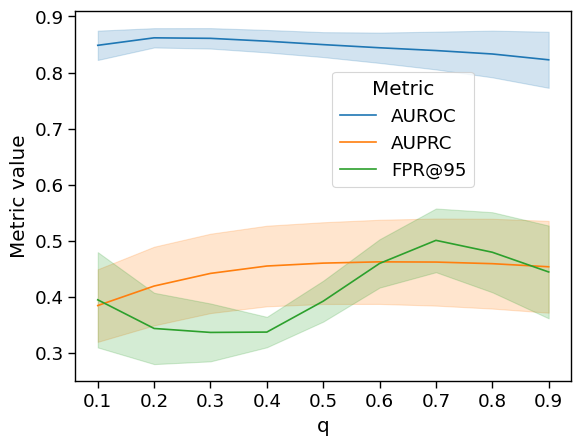

In [335]:
# Sensitivity to q
import seaborn as sns

sns.set_context("paper", font_scale=1.5)
qdf["metric"] = qdf["metric"].replace({"auc": "AUROC",
                                      "ap": "AUPRC",
                                      "fpr95": "FPR@95"})
f = sns.lineplot(qdf,
             x="q",
             y="value",
             hue="metric",
             errorbar=("se", 2))
f.set_xlabel("q")
f.set_ylabel("Metric value")
plt.legend(bbox_to_anchor=[0.5,0.5], title="Metric")
plt.savefig("q_value.pdf", bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>

In [212]:
H_means = []
pred_means = []
for label, model_name in zip(config["labels"], config["ckpts"]):
    df_pred, n_col = load_data(label, model_name)

    # Pred means
    taxa = df_pred.columns[2:-1]
    assert len(taxa) == 39

    ## Rows with the outlier predictions are removed
    pred_means.append(df_pred.melt(id_vars="y_true",
                value_vars=taxa)
            .query("y_true != @label and variable != @label")
            .groupby(["y_true", "variable"])["value"].mean())


    # Entropy means
    df_pred = calc_classifier_metrics(df_pred, n_col)
    label_H_mean = df_pred.groupby("y_true")["H"].mean()
    label_H_mean.name = label
    H_means.append(label_H_mean)
    print(label)

Agapetus_sp
Ameletus_inopinatus
Amphinemura_borealis
Baetis_rhodani
Baetis_vernus_group
Capnopsis_schilleri
Diura_sp
Elmis_aenea
Ephemerella_aurivillii
Ephemerella_mucronata
Heptagenia_sulphurea
Hydraena_sp
Hydropsyche_pellucidula
Hydropsyche_saxonica
Hydropsyche_siltalai
Isoperla_sp
Kageronia_fuscogrisea
Lepidostoma_hirtum
Leptophlebia_sp
Leuctra_nigra
Leuctra_sp
Limnius_volckmari
Micrasema_gelidum
Micrasema_setiferum
Nemoura_cinerea
Nemoura_sp
Neureclipsis_bimaculata
Oulimnius_tuberculatus
Oxyethira_sp
Plectrocnemia_sp
Polycentropus_flavomaculatus
Polycentropus_irroratus
Protonemura_sp
Rhyacophila_nubila
Sialis_sp
Silo_pallipes
Simuliidae
Sphaerium_sp
Taeniopteryx_nebulosa


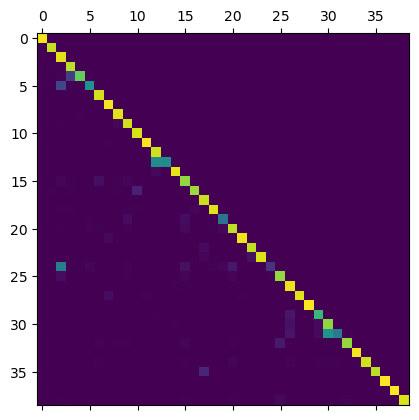

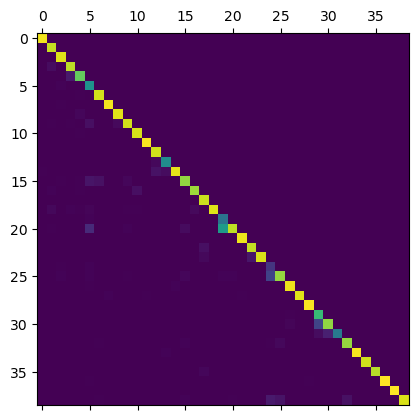

In [24]:
pred_df = pd.concat(pred_means).reset_index().groupby(["y_true", "variable"]).mean()
pred_dist = pred_df.unstack().values
pred_dist_lower = np.tril(pred_dist)
pred_dist_upper = np.triu(pred_dist).T
plt.matshow(pred_dist_lower)
plt.matshow(pred_dist_upper)

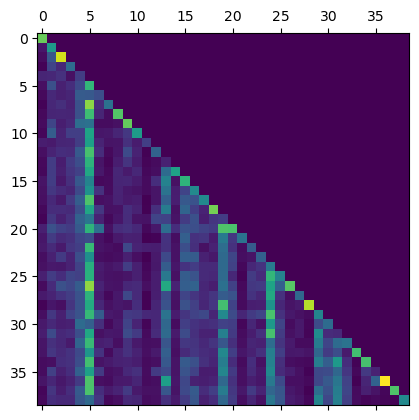

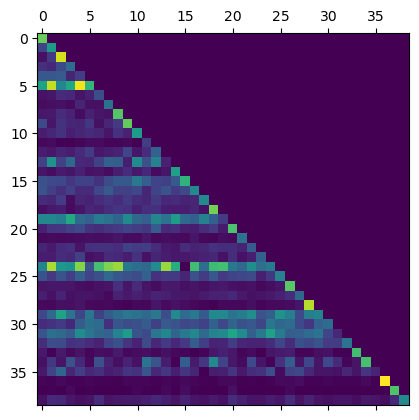

In [25]:
H_dist = pd.DataFrame(H_means).sort_index()
H_dist_lower = np.tril(H_dist)
H_dist_upper = np.triu(H_dist).T
plt.matshow(H_dist_lower)
plt.matshow(H_dist_upper)

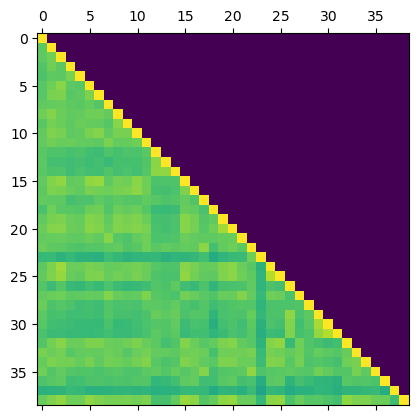

In [26]:
D_lower = np.tril(D)
plt.matshow(D_lower)

C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\3619067569.py:2: RuntimeWarning: divide by zero encountered in log
  x = np.log(pred_dist_lower.ravel())
C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\3619067569.py:9: RuntimeWarning: divide by zero encountered in log
  x = np.log(pred_dist_upper.ravel())
C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\3619067569.py:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(H_dist_lower.ravel())
C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\3619067569.py:21: RuntimeWarning: divide by zero encountered in log
  x = np.log(H_dist_upper.ravel())


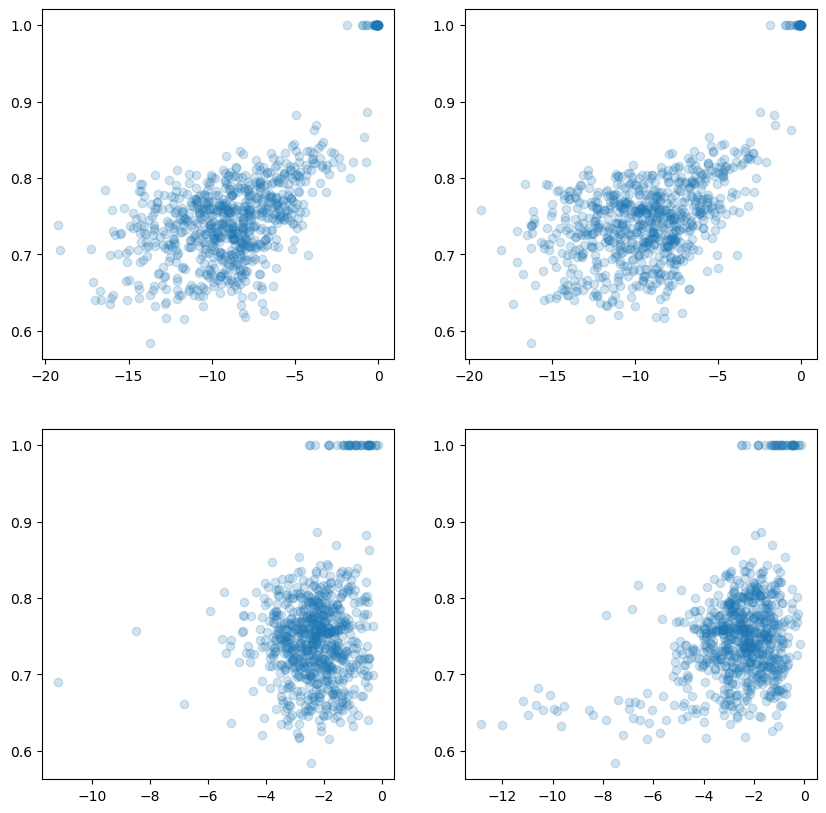

In [42]:
fig,ax =plt.subplots(2,2,figsize=(10,10))
x = np.log(pred_dist_lower.ravel())
y = D_lower.ravel()
ax[0][0].scatter(x,
            y,
            alpha=0.2
            )

x = np.log(pred_dist_upper.ravel())
ax[0][1].scatter(x,
            y,
            alpha=0.2
            )

x = np.log(H_dist_lower.ravel())
ax[1][0].scatter(x,
            y,
            alpha=0.2
            )

x = np.log(H_dist_upper.ravel())
ax[1][1].scatter(x,
            y,
            alpha=0.2
            )

In [43]:
from sklearn.metrics import confusion_matrix

In [81]:
top3_df = []
for label, model_name in zip(config["labels"], config["ckpts"]):
    print(label)
    df_pred, n_col = load_data(label, model_name)

    # Pred means
    taxa = df_pred.columns[2:-1]
    assert len(taxa) == 39

    cm = confusion_matrix(df_pred.y_true, df_pred.y_pred, labels=taxa,normalize="true")
    assert cm.shape == (39,39)

    outlier_preds = cm[0]
    ind = np.argsort(outlier_preds)[::-1][:3]
    top3 = taxa[ind]
    top3_p = outlier_preds[ind]
    top3_dna = D.loc[label][top3].values
    top3_dna_rank = D.loc[label].argsort()[top3].values

    top3_df.append(pd.DataFrame({"outlier":label,
                "rank": np.arange(1,4),
                "taxa": top3,
                "pred_p": top3_p,
                "DNA_dist": top3_dna,
                "DNA_rank": top3_dna_rank})
    )

Agapetus_sp
Ameletus_inopinatus
Amphinemura_borealis
Baetis_rhodani
Baetis_vernus_group
Capnopsis_schilleri
Diura_sp
Elmis_aenea
Ephemerella_aurivillii
Ephemerella_mucronata
Heptagenia_sulphurea
Hydraena_sp
Hydropsyche_pellucidula
Hydropsyche_saxonica
Hydropsyche_siltalai
Isoperla_sp
Kageronia_fuscogrisea
Lepidostoma_hirtum
Leptophlebia_sp
Leuctra_nigra
Leuctra_sp
Limnius_volckmari
Micrasema_gelidum
Micrasema_setiferum
Nemoura_cinerea
Nemoura_sp
Neureclipsis_bimaculata
Oulimnius_tuberculatus
Oxyethira_sp
Plectrocnemia_sp
Polycentropus_flavomaculatus
Polycentropus_irroratus
Protonemura_sp
Rhyacophila_nubila
Sialis_sp
Silo_pallipes
Simuliidae
Sphaerium_sp
Taeniopteryx_nebulosa


In [91]:
top3 = pd.concat(top3_df).reset_index(drop=True)
top3 = top3.pivot(index="outlier",columns="rank",values=["taxa", "pred_p", "DNA_dist", "DNA_rank"]).stack()
top3 = top3.astype({"pred_p": np.float64,
             "DNA_dist": np.float64,
             "DNA_rank": float})
top3

taxa    pred_p  DNA_dist  \
outlier               rank                                                
Agapetus_sp           1        Hydropsyche_siltalai  0.305971  0.744681   
                      2     Neureclipsis_bimaculata  0.197887  0.734043   
                      3          Lepidostoma_hirtum  0.152082  0.759878   
Ameletus_inopinatus   1              Baetis_rhodani  0.577687  0.782675   
                      2             Leptophlebia_sp  0.242357  0.779635   
...                                             ...       ...       ...   
Sphaerium_sp          2                  Simuliidae  0.249856  0.620061   
                      3     Hydropsyche_pellucidula  0.167917  0.633739   
Taeniopteryx_nebulosa 1              Protonemura_sp  0.435283  0.828267   
                      2                  Nemoura_sp  0.395100  0.832827   
                      3                 Isoperla_sp  0.065605  0.844985   

                            DNA_rank  
outlier               rank            
Agapetus_sp           1         14.0  
                      2         10.0  
                      3         13.0  
Ameletus_inopinatus   1         26.0  
                      2         33.0  
...                              ...  
Sphaerium_sp          2         22.0  
                      3          0.0  
Taeniopteryx_nebulosa 1         19.0  
                      2         11.0  
                      3          0.0  

[117 rows x 4 columns]

In [92]:
import plotly.express as px
px.scatter(top3.reset_index(),
           x="pred_p",
           y="DNA_dist",
           color="DNA_rank",
           hover_data=["outlier", "taxa"],
           width=800,
           height=800)

In [85]:
np.corrcoef(top3.pred_p.values,
            top3.DNA_dist.values)

array([[1.        , 0.29414248],
       [0.29414248, 1.        ]])

In [97]:
np.corrcoef(top3.reset_index()["rank"],
            top3.reset_index().DNA_rank)

array([[ 1.        , -0.15090298],
       [-0.15090298,  1.        ]])

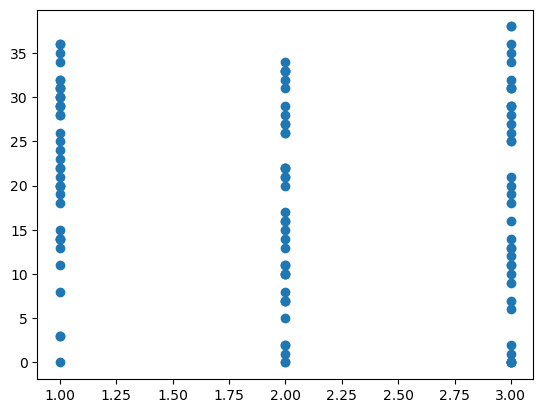

In [98]:
plt.scatter(top3.reset_index()["rank"],
            top3.reset_index().DNA_rank)